In [63]:
import json
import random
import os
import sys
sys.path.insert(1, os.path.join(sys.path[0], '..'))  # Add the src directory to path 
from src.utils import tight_bbox, format_number

import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
from matplotlib.colors import ListedColormap, BoundaryNorm
from matplotlib.lines import Line2D
from matplotlib import cm
import matplotlib
from mpl_toolkits.axes_grid1 import make_axes_locatable

plt.style.use('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle')
import numpy as np
import seaborn as sns

from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import linkage

In [7]:
colors = json.load(open(r'..\data\metadata\color_schemes.json'))
compound_superclasses = json.load(open('../data/metadata/compound_superclasses.json', 'r'))
    
data = pd.read_csv(r'../data/processed/combined_metabolites_data_with_model_params.csv').set_index('i')
data_cols = data.filter(regex='_FBG|_RBG').columns
fbg_cols = data.filter(regex='_FBG').columns
rbg_cols = data.filter(regex='_RBG').columns

ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)
fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)
#### REMOVE OUTLIER ####
fg = fg.drop('1091_9_FBG')

# PCA plot

In [67]:
plt.rcParams['axes.unicode_minus'] = False

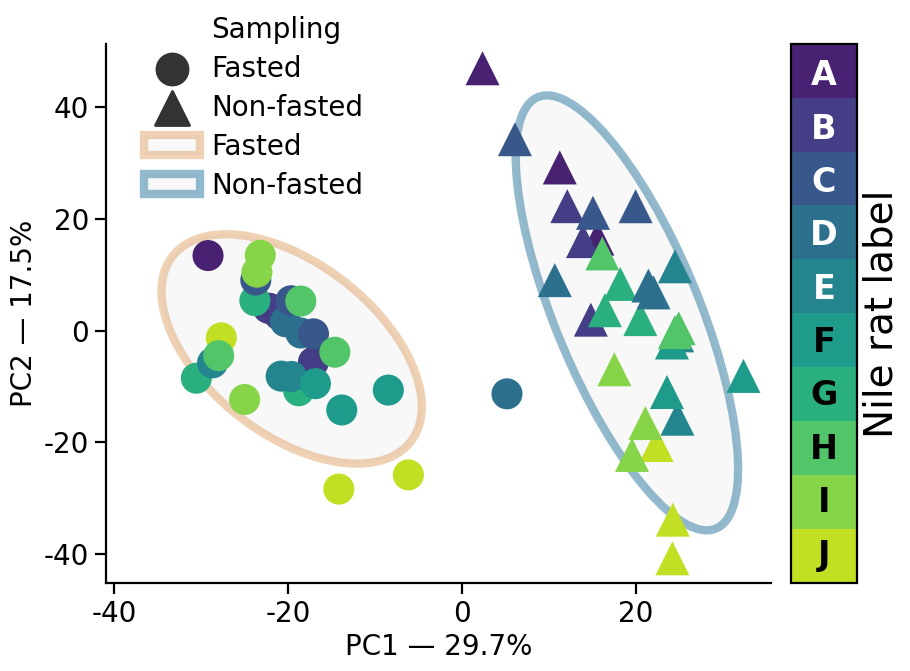

In [69]:
scaled = StandardScaler().fit_transform(data[data_cols].T)
pca_object = PCA(n_components=10).fit(scaled)
pca = pca_object.transform(scaled)
pc_columns = [f'pc{x}' for x in range(1, pca_object.n_components+1)]
pca = pd.DataFrame(pca, index=data_cols, columns=pc_columns)
pca = pca.join(fg[['animal', 'bg_type', 'week']])
pca['animal'] = pca['animal'].astype('str')
pca = pca.rename({'bg_type': 'Sampling'}, axis=1)
pca['Sampling'] = pca['Sampling'].map({'RBG': 'Non-fasted', 'FBG': 'Fasted'})
loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_), 
                        index=data.index, columns=pc_columns)
loadings['pc1_rank'] = loadings['pc1'].abs().rank(ascending=False)
loadings['pc2_rank'] = loadings['pc2'].abs().rank(ascending=False)
loadings = loadings.join(data['ID'])
loadings.loc[loadings['ID'] != 'unknown'].sort_values('pc2_rank').iloc[:20]

# Draw confidence intervals around data: 
# From https://stackoverflow.com/a/25022642
def make_ci(x, y, std=2, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, 
                      **kwargs)
    return ellipse

def pca_plot(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.85, 3.5), dpi=200)
    sns.scatterplot(
        data=pca, x='pc1', y='pc2', hue='animal', palette=colors,
        style='Sampling', markers={'Non-fasted': '^', 'Fasted': 'o'}, 
        size='Sampling', sizes={'Non-fasted': 150, 'Fasted':125},
        legend=True, alpha=1, linewidth=0, edgecolor='0.15',
        ax=ax)
    ax.set_xlabel(f'PC1 — {round(100*pca_object.explained_variance_ratio_[0], 1)}%', fontsize=10) 
    ax.set_ylabel(f'PC2 — {round(100*pca_object.explained_variance_ratio_[1], 1)}%', fontsize=10) 
    ax.tick_params(labelsize=10, length=4, pad=2)
    ax.set_xlim(-41, ax.get_xlim()[1])
    # plt.legend(loc=(1.4, 0), fontsize=14, markerscale=2)

    # Discrete colorbar 
    # https://stackoverflow.com/a/48269806  code source
    divider = make_axes_locatable(ax)
    cax = divider.append_axes('right', size='10%', pad=0.1)
    cmap = ListedColormap(sns.color_palette('viridis_r', 10))
    norm = BoundaryNorm(np.arange(0, 10 + 1) - 0.5, 10)
    sm = plt.cm.ScalarMappable(cmap=cmap, norm=norm)
    sm.set_array([])
    cb = plt.colorbar(sm, cax=cax, shrink=0.5)
#     cb.ax.set_yticks(range(10), labels=[_ for _ in 'JIHGFEDCBA'], fontsize=10)
    cb.ax.set_yticks([])
    cb.ax.tick_params(length=0, pad=2, labelsize=14)
    cb.ax.set_ylabel('Nile rat label', fontsize=14)
#     cb.ax.yaxis.tick_left()

    for L, y in zip('ABCDEFGHIJ', range(9, -1, -1)):
        color = ('white' if y > 4 else 'black')
        cb.ax.text(0.5, 0.99*y, L, ha='center', va='center', color=color, fontsize=12, fontweight='bold')

    for bg_type in ['Fasted', 'Non-fasted']:
        df = pca.loc[pca['Sampling'] == bg_type]
        ci_ellipse = make_ci(
            x=df['pc1'], y=df['pc2'],            
            edgecolor=colors[bg_type], facecolor=(0.95, 0.95, 0.95),
            linewidth=3, alpha=0.5, zorder=0, label=bg_type,)
        ax.add_artist(ci_ellipse)
    # plt.legend()
    handles, labels = ax.get_legend_handles_labels()
    ax.legend(handles=handles[11:], labels=labels[11:], loc=(0.05, 0.7), title_fontsize=10, fontsize=10)
    sns.despine(ax=ax)
pca_plot()
plt.savefig('../reports/figures/Figure2/PCA.pdf', pad_inches=0, 
            dpi=300, bbox_inches='tight')

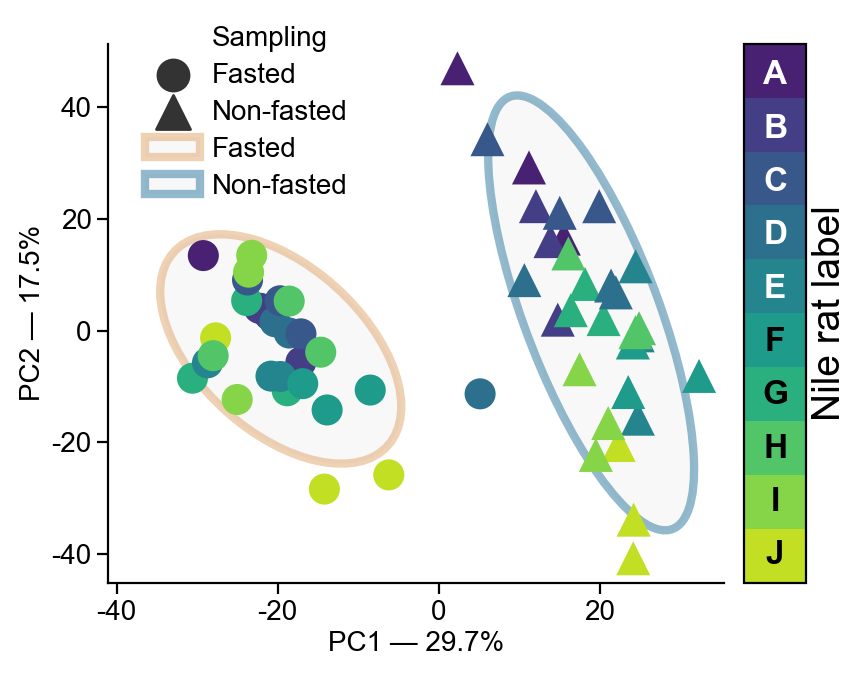

In [61]:
with plt.style.context('../data/metadata/Nilerat_matplotlib_stylesheet.mplstyle'):
    pca_plot()

# Pie chart

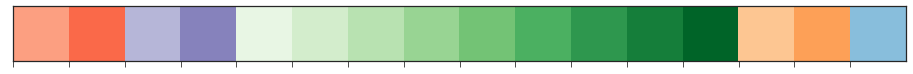

In [52]:
# lsc = Lipid Super Classes
lsc = (data  
    .loc[data['Type'] == 'lipid', 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
    )
lc = (data  # lc = Lipid Classes
    .loc[(data['Type'] == 'lipid') & (data['superclass'] != 'Unidentified'), 'molec_class']
    .value_counts()
    .to_frame()
     )
lc['superclass'] = lc.index.map(compound_superclasses)
lc = lc.sort_values('superclass')
lc_counts = lc['molec_class']
lc_names = lc.index

mc = (data  # mc = Metabolite Classes
    .loc[(data['Type'] == 'metabolite') & (data['ID'] != 'unknown'), 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
     )

lipid_class_color_gradient = (
    list(sns.color_palette('Reds', 5)[1:3]) +
    list(sns.color_palette('Purples', 4)[1:3]) + 
    list(sns.color_palette('Greens', 9)[::1]) +
    list(sns.color_palette('Oranges', 6)[1:3]) +
    list(sns.color_palette('Blues', 6)[2:3])
)
sns.palplot(lipid_class_color_gradient)


startangle = 25
def lipid_pie(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect('equal')
    wedges, texts = ax.pie(
        lsc,
    #     explode=[0.02]*5,  # expand the slices away from the center
        labels=lsc.index, #lsc.astype('str') + ' ' + lsc.index.astype('str'), 
        labeldistance=0.80,
        colors=lsc.index.map(colors),
        radius=1,
        wedgeprops=dict(width=0.4),
        textprops=dict(fontsize=10, fontweight='bold', ha='center'),
        rotatelabels=False,
        startangle=startangle,
    )
    [text.set_text(count) for text, count in zip(texts, lsc)]  # Set numbers here, so that legend contains names

    ax.legend(loc=(-1, 0.3), fontsize=10, title='Lipid Superclass', title_fontsize=10)
    outer_wedges, outer_texts = ax.pie(
        lc_counts,
        labels=lc_names,
        labeldistance=1.03, 
    #     explode=[0.05] * len(lc),
        radius=1.32,
        wedgeprops=dict(width=0.3),
    #     colors=['gray', 'lightgray'],
        colors=lipid_class_color_gradient,
        textprops=dict(fontsize=10),
        startangle=startangle,
    )
    ax.text(0, 0, f'{lsc.sum()} Lipids', fontsize=10, fontweight='semibold', ha='center', va='center')

def metabolite_pie(ax=None):
    if ax is None:
        fig, ax = plt.subplots()
    ax.set_aspect('equal')
    m_wedges, m_texts = ax.pie(
        mc,
        labels=mc.index.astype('str').str.capitalize(),
        labeldistance=0.80,
        radius=1.32,
    #     colors=sns.color_palette('deep', len(mc), desat=1),
    #     colors=random.sample(sns.color_palette('tab10', 11)[5:], 6, ),#[::-1],
    #     colors=sns.color_palette('Set2', 12, desat=1)[6:12],#[::-1],
    #     colors=sns.color_palette('husl', 6),
        colors=mc.index.map(colors),
        wedgeprops=dict(width=0.5),
        textprops=dict(fontsize=10, fontweight='bold', ha='center', ),
        startangle=45,
    )
    [text.set_text(count) for text, count in zip(m_texts, mc)]
    ax.legend(loc=(-0.8, 0.3), fontsize=10, title='Metabolite Class', title_fontsize=10)
    ax.text(0, 0, f'{mc.sum()} Polar\nMetabolites', fontsize=10, fontweight='semibold', ha='center', va='center')


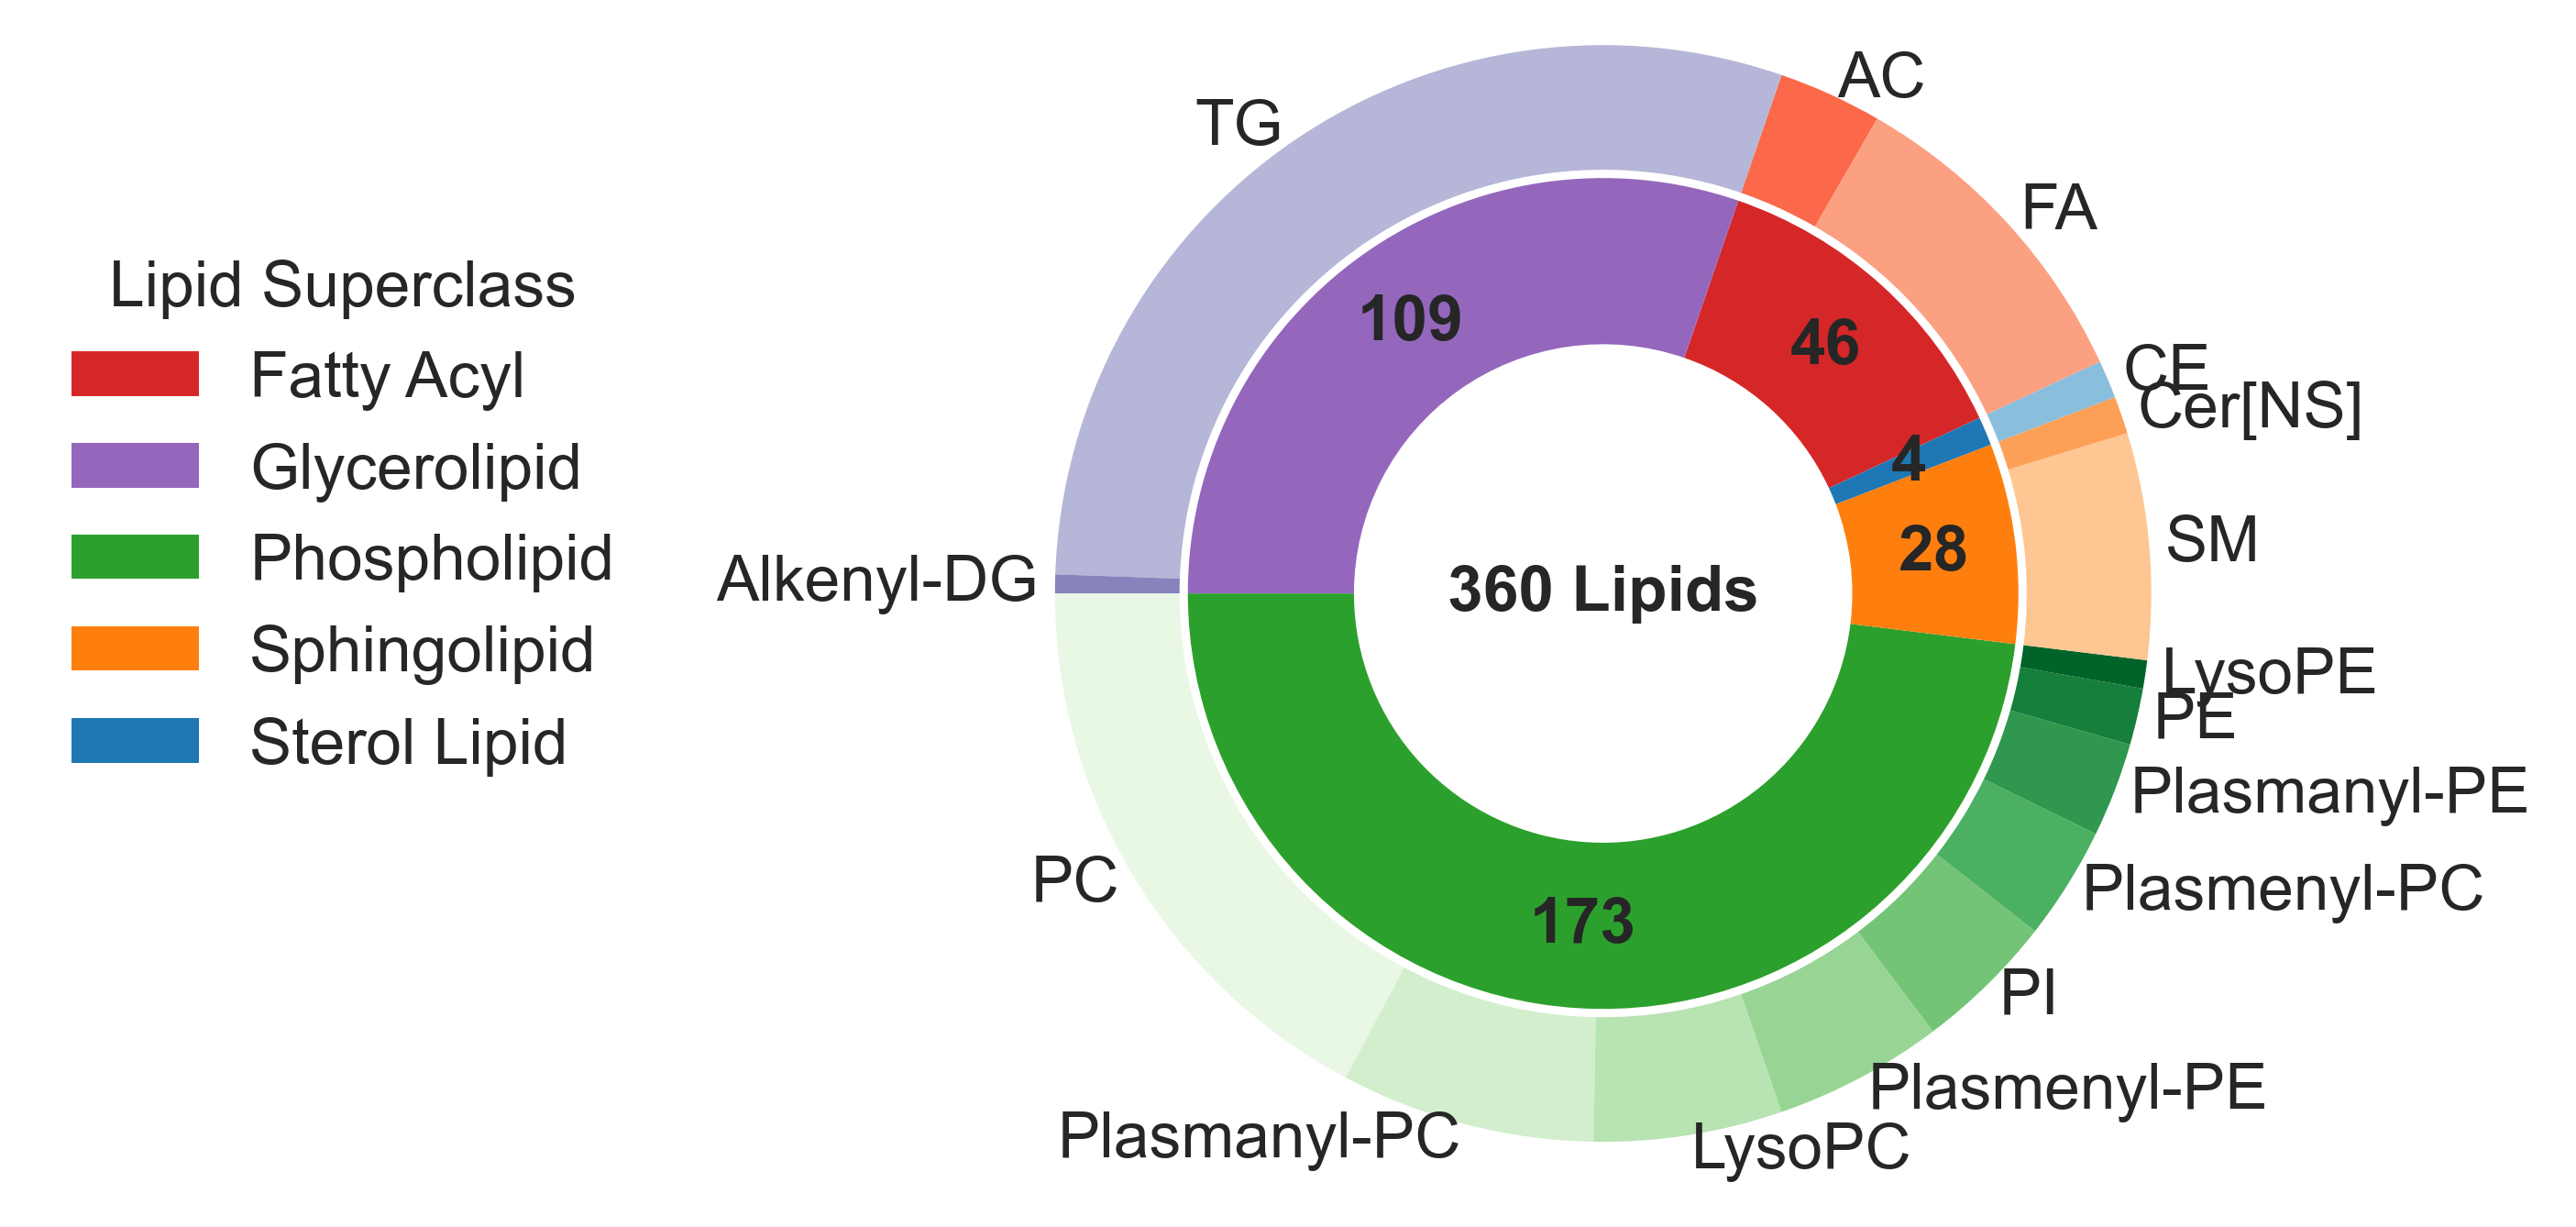

In [62]:
fig, ax = plt.subplots(figsize=(3,3), dpi=500)
lipid_pie(ax=ax)
# plt.savefig('../reports/figures/Figure2/lipid_pie_chart.pdf', dpi=300, bbox_inches='tight')

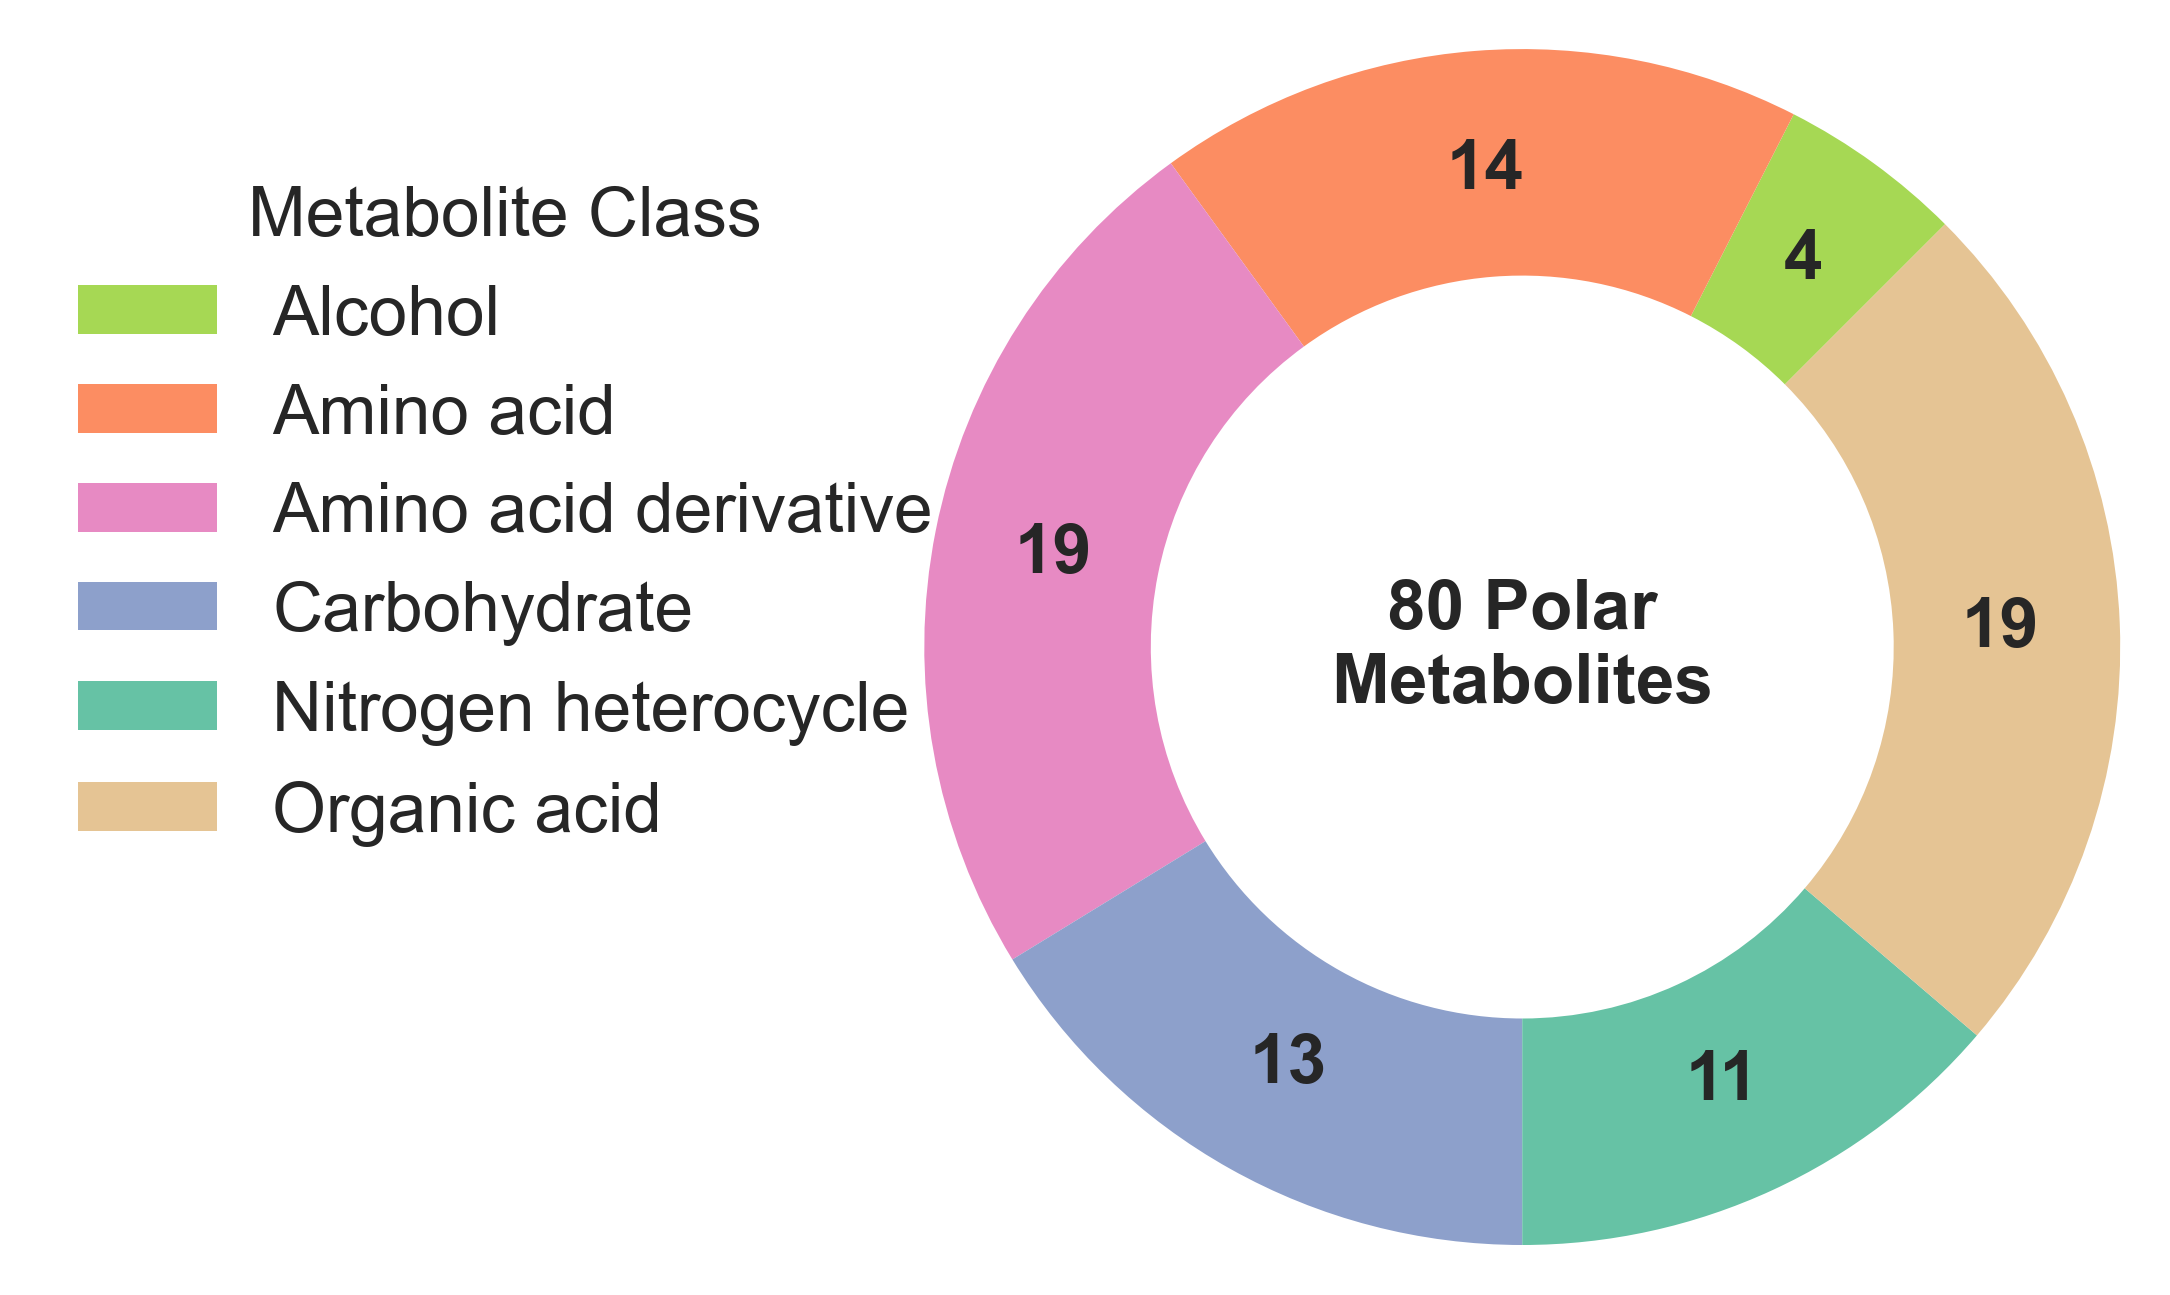

In [18]:
fig, ax = plt.subplots(figsize=(3,3), dpi=500)
metabolite_pie(ax=ax)
# plt.savefig('../reports/figures/Figure2/metab_pie_chart.pdf', dpi=300, bbox_inches='tight')

GridSpec(3, 3, height_ratios=[0.001, 0.04, 0.959], width_ratios=[0.15, 0.08, 0.77])

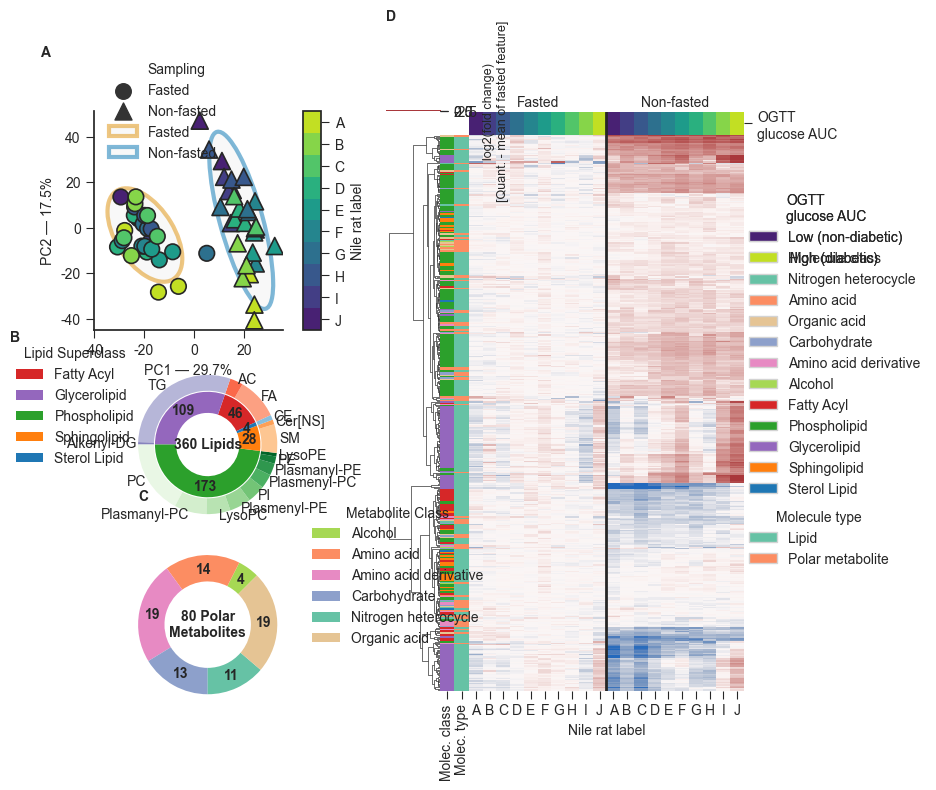

In [7]:
data['Molec. class'] = data['molec_class'].map(colors)
data['Molec. type'] = data['Type'].map(colors)
df = data.loc[data['ID'] != 'Unidentified']

cm_data = data.loc[:, fg.index].T

# Normalize the data to the average of the lipid or metabolite across all fasted samples 
fbg_means = data.loc[:, fbg_cols].mean(axis=1)
cm_data = (cm_data
           .subtract(fbg_means)
           .join(fg[['animal', 'bg_type']])
           .groupby(['animal', 'bg_type'])
           .mean()
           .reset_index()
           .join(ap['OGTT (AUC)'], on='animal')
           .sort_values(['bg_type', 'OGTT (AUC)'], ascending=[True, True])
          )
cm_data['animal_color'] = cm_data['animal'].astype('str').map(colors)
cm_data

rbg_clust = linkage(cm_data.loc[cm_data['bg_type'] == 'RBG', df.index].T, 
                    method='complete', metric='euclidean')
        
cm = sns.clustermap( 
    data=cm_data[df.index].T,
    row_linkage=rbg_clust, col_cluster=False, 
    row_colors=df[['Molec. class', 'Molec. type']], 
    col_colors=cm_data[['animal_color']],
    cmap='vlag', 
    dendrogram_ratio=(0.15, 0.001),
    colors_ratio=0.04,
#     legend=True,
    cbar_kws=dict(label='log2(fold change)\n[Quant. - mean of fasted TG]', aspect='10', extend='max'),
    figsize=(6.5, 7), 
    cbar_pos=(0.9, 0.1, 0.03, 0.18),
    tree_kws={'linewidth': 0.5},
    #### HEATMAP ARGUMENTS #### 
    center=0, vmin=-4, vmax=4,
    yticklabels=False,
)

cm.ax_heatmap.set_xticks(np.arange(0.5, 20.5, 1), labels='ABCDEFGHIJ'*2, rotation=0, fontsize=10)
cm.ax_heatmap.set_xlabel('Nile rat label', fontsize=10)
cm.ax_heatmap.axvline(   x=10, c='0.15', linewidth=2)
cm.ax_col_colors.axvline(x=10, c='0.15', linewidth=2)

cm.ax_cbar.set_ylabel('log2(fold change)\n[Quant. - mean of fasted feature]', fontsize=9)
cm.ax_col_colors.set_yticklabels(['OGTT\nglucose AUC'], fontsize=10)
cm.ax_col_colors.text(s='Fasted', x=5, y=-0.4, fontsize=10, ha='center', va='center')
cm.ax_col_colors.text(s='Non-fasted', x=15, y=-0.4, fontsize=10, ha='center', va='center')

legend_loc = 1.0
handles, labels = [], []
for superclass in data['superclass'].unique():
    s_color = colors[superclass]
    labels.append(superclass)
    handles.append(Patch(edgecolor='lightgray', facecolor=s_color))
legend1 = plt.legend(
    handles[1:], labels[1:],  ## [1:] TO REMOVE UNIDENTIFIED FROM LEGEND  
    title='Molecule class', bbox_to_anchor=(legend_loc, 0.42), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend1)

labels = ['Lipid', 'Polar metabolite']
handles = [Patch(facecolor=colors['lipid'], edgecolor='lightgray'), 
           Patch(facecolor=colors['metabolite'], edgecolor='lightgray')]
legend2 = plt.legend(handles, labels, title='Molecule type', 
           bbox_to_anchor=(legend_loc, 0.32), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend2)

labels = ['Low (non-diabetic)', 'High (diabetic)']
handles = [Patch(facecolor=colors[str(ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].idxmin())], edgecolor='lightgray'), 
           Patch(facecolor=colors[str(ap.loc[ap['lcms_sampled'], 'OGTT (AUC)'].idxmax())], edgecolor='lightgray')]
legend3 = plt.legend(handles, labels, title='OGTT\nglucose AUC', 
           bbox_to_anchor=(legend_loc, 0.75), bbox_transform=cm.fig.transFigure, loc=(0.5, 0.5))
cm.fig.add_artist(legend3)

# https://stackoverflow.com/a/51813562/8659119
# display(cm.gs)
cm.gs.update(left=0.45, right=1, )
gs2 = plt.GridSpec(nrows=3, ncols=1, left=0, right=0.35, height_ratios=[0.5, 0.3, 0.3], hspace=0.3)
axpca = cm.fig.add_subplot(gs2[0])
axpie1 = cm.fig.add_subplot(gs2[1])
axpie2 = cm.fig.add_subplot(gs2[2])
pca_plot(ax=axpca)
lipid_pie(ax=axpie1)
metabolite_pie(ax=axpie2)
display(cm.gs)
cm.fig.set_dpi(100)


# label axes
for ax, letter in zip([axpca, axpie1, axpie2, cm.cax], 'ABCD'):
        bb = tight_bbox(ax)
        ax.text(x=bb.x0, y=bb.y1, s=letter, transform=cm.fig.transFigure, fontweight='bold')
# plt.savefig('../reports/figures/Figure2/combined.pdf', dpi=150, bbox_inches='tight', facecolor='white')
# plt.savefig('../reports/figures/Figure2/combined.png', dpi=150, bbox_inches='tight', facecolor='white')

In [202]:
gs2

GridSpec(3, 1, height_ratios=[0.5, 0.3, 0.3])

In [201]:
cm.gs

GridSpec(3, 3, height_ratios=[0.001, 0.04, 0.959], width_ratios=[0.15, 0.08, 0.77])

## PCA code originally in `BJA-3.5.1.1` 

,pc1,pc2,pc3,pc4,pc5,pc6,pc7,pc8,pc9,pc10,pc1_rank,pc2_rank,ID
i,,,,,,,,,,,,,
l_815,0.005437,-0.987947,-0.023684,0.085271,-0.051575,-0.003435,-0.022896,-0.062239,0.038834,0.000117,1403.0,1.0,TG 56:5
l_705,0.007544,-0.979499,-0.071189,0.059462,-0.037468,-0.019408,0.027139,-0.059842,-0.054221,-0.000220,1399.0,2.0,TG 56:7
l_704,-0.077470,-0.976484,-0.067602,0.101398,0.074842,-0.031175,0.035034,-0.085197,0.012529,-0.041330,1271.0,3.0,Unidentified
l_625,-0.038632,-0.975783,-0.065461,0.054549,-0.087197,-0.080473,0.057296,0.000873,-0.042133,0.035904,1332.0,4.0,Unidentified
l_816,-0.079648,-0.975218,0.000010,0.112928,-0.066054,-0.039916,-0.008773,-0.046111,0.028131,0.055355,1267.0,5.0,Unidentified
l_683,-0.064837,-0.973434,-0.017188,-0.013652,-0.105034,-0.017392,0.057768,-0.057038,0.005942,0.039481,1290.0,6.0,TG 58:9
l_731,0.040184,-0.969609,-0.074110,0.135440,0.105824,-0.033780,0.046504,-0.052441,0.075240,-0.016767,1327.0,7.0,TG 52:4
l_817,-0.067264,-0.968622,0.012261,0.102112,-0.108059,0.015092,-0.002812,-0.085491,0.000927,0.026999,1285.0,8.0,Unidentified
l_760,-0.081005,-0.965751,-0.091531,0.026815,0.075421,-0.032818,-0.090539,-0.038432,0.038964,0.018541,1265.0,9.0,TG 54:5


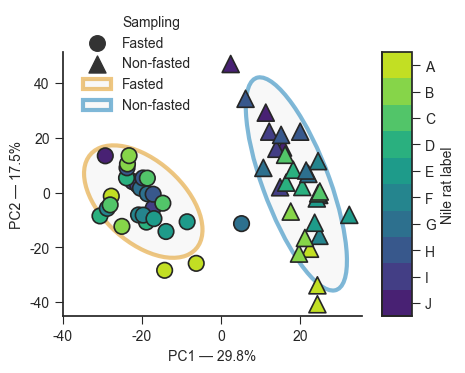

# OLD CODE BELOW

# Pie charts

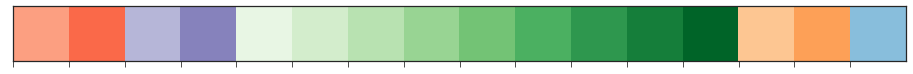

In [166]:
# lsc = Lipid Super Classes
lsc = (data  
    .loc[data['Type'] == 'lipid', 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
    )
lc = (data  # lc = Lipid Classes
    .loc[(data['Type'] == 'lipid') & (data['superclass'] != 'Unidentified'), 'molec_class']
    .value_counts()
    .to_frame()
     )
lc['superclass'] = lc.index.map(compound_superclasses)
lc = lc.sort_values('superclass')
lc_counts = lc['molec_class']
lc_names = lc.index

mc = (data  # mc = Metabolite Classes
    .loc[(data['Type'] == 'metabolite') & (data['ID'] != 'unknown'), 'superclass']
    .value_counts()
    .drop('Unidentified')
    .sort_index()
     )

lipid_class_color_gradient = (
    list(sns.color_palette('Reds', 5)[1:3]) +
    list(sns.color_palette('Purples', 4)[1:3]) + 
    list(sns.color_palette('Greens', 9)[::1]) +
    list(sns.color_palette('Oranges', 6)[1:3]) +
    list(sns.color_palette('Blues', 6)[2:3])
)
sns.palplot(lipid_class_color_gradient)

Text(0, 0, '80 Polar\nMetabolites')

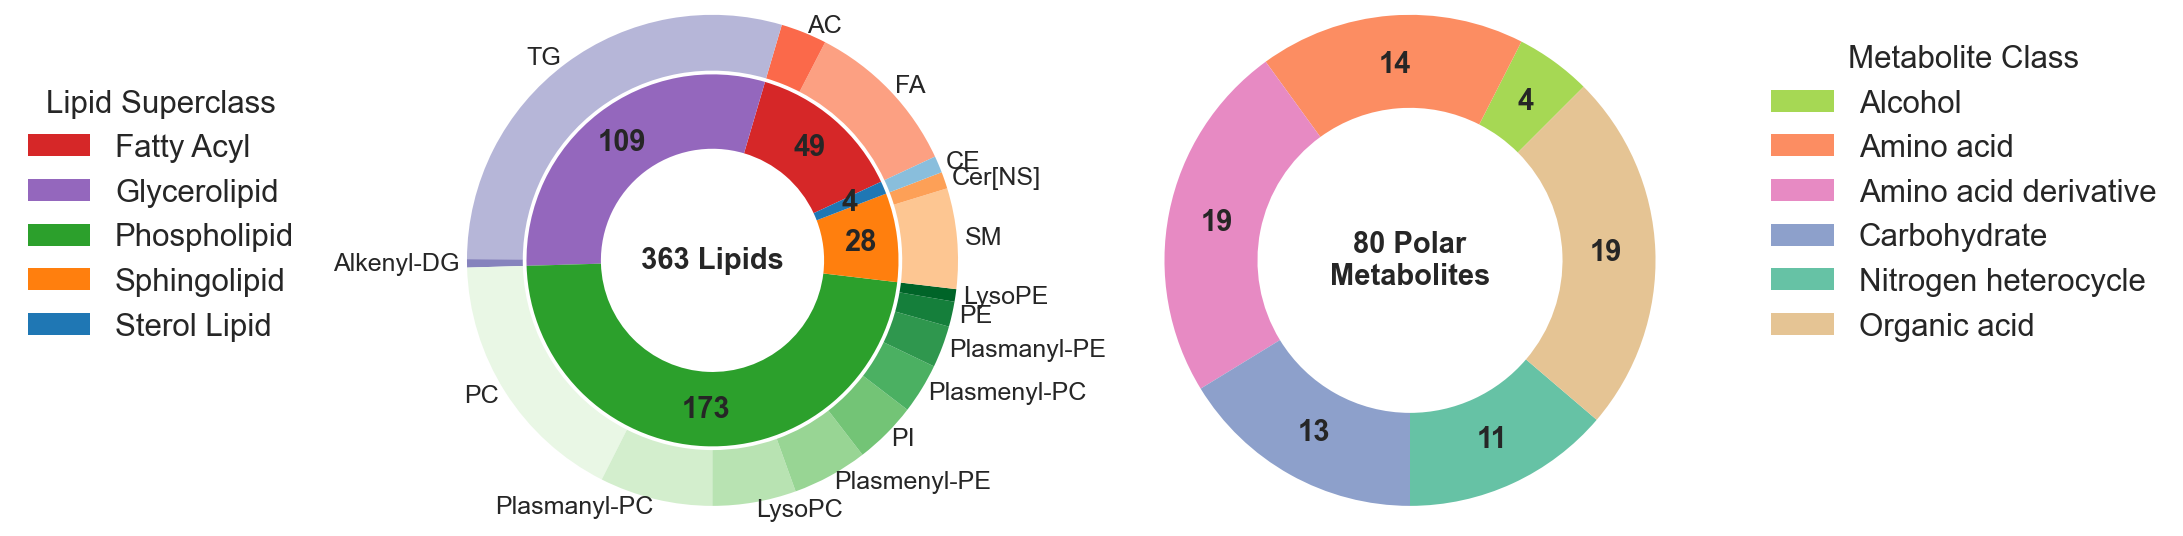

In [167]:
fig, axs = plt.subplots(ncols=2, figsize=(10,5), gridspec_kw={'wspace': 0.5}, dpi=150)
axs[0].set_aspect('equal'), axs[1].set_aspect('equal')
ax = axs[0]
startangle=25
wedges, texts = ax.pie(
    lsc,
#     explode=[0.02]*5,  # expand the slices away from the center
    labels=lsc.index, #lsc.astype('str') + ' ' + lsc.index.astype('str'), 
    labeldistance=0.80,
    colors=lsc.index.map(colors),
    radius=1,
    wedgeprops=dict(width=0.4),
    textprops=dict(fontsize=14, fontweight='bold', ha='center'),
    rotatelabels=False,
    startangle=startangle,
)
[text.set_text(count) for text, count in zip(texts, lsc)]  # Set numbers here, so that legend contains names

ax.legend(loc=(-1, 0.3), fontsize=15, title='Lipid Superclass', title_fontsize=15)
outer_wedges, outer_texts = ax.pie(
    lc_counts,
    labels=lc_names,
    labeldistance=1.03, 
#     explode=[0.05] * len(lc),
    radius=1.32,
    wedgeprops=dict(width=0.3),
#     colors=['gray', 'lightgray'],
    colors=lipid_class_color_gradient,
    textprops=dict(fontsize=12),
    startangle=startangle,
)
ax.text(0, 0, f'{lsc.sum()} Lipids', fontsize=14, fontweight='semibold', ha='center', va='center')

ax = axs[1]
random.seed(5)
m_wedges, m_texts = ax.pie(
    mc,
    labels=mc.index.astype('str').str.capitalize(),
    labeldistance=0.80,
    radius=1.32,
#     colors=sns.color_palette('deep', len(mc), desat=1),
#     colors=random.sample(sns.color_palette('tab10', 11)[5:], 6, ),#[::-1],
#     colors=sns.color_palette('Set2', 12, desat=1)[6:12],#[::-1],
#     colors=sns.color_palette('husl', 6),
    colors=mc.index.map(colors),
    wedgeprops=dict(width=0.5),
    textprops=dict(fontsize=14, fontweight='bold', ha='center', ),
    startangle=45,
)
[text.set_text(count) for text, count in zip(m_texts, mc)]
ax.legend(loc=(1.25, 0.3), fontsize=15, title='Metabolite Class', title_fontsize=15)
ax.text(0, 0, f'{mc.sum()} Polar\nMetabolites', fontsize=14, fontweight='semibold', ha='center', va='center')

# plt.savefig('../reports/figures/Figure2/Piecharts.pdf', dpi=150, bbox_inches='tight')

# Clustermap of all data
## Original heatmap code from `BJA-4.3.2-RvsF`
## Better code from `BJA-4.5.5-FigTGs-heatmap`

In [65]:
cm_data.columns

Index(['animal', 'bg_type', 'm_0', 'm_1', 'm_2', 'm_3', 'm_4', 'm_5', 'm_6',
       'm_7',
       ...
       'l_909', 'l_910', 'l_911', 'l_912', 'l_913', 'l_914', 'l_915', 'l_916',
       'OGTT (AUC)', 'animal_color'],
      dtype='object', length=1416)

,animal,bg_type,m_0,m_1,m_2,m_3,m_4,m_5,m_6,m_7,...,l_909,l_910,l_911,l_912,l_913,l_914,l_915,l_916,OGTT (AUC),animal_color
10,1091,FBG,-0.324829,-0.044195,0.583903,0.299492,3.084653,0.173744,0.137227,0.027010,...,-0.946199,-0.954755,-0.854708,-0.450917,-0.988218,-0.105200,-0.231358,0.048171,19060.0,"[0.283072, 0.130895, 0.449241]"
14,1093,FBG,-0.890192,0.009772,-0.424220,0.025255,2.814963,0.200678,0.153349,0.427658,...,1.067399,1.246631,1.175923,0.484855,1.754183,1.278622,1.241118,1.405725,25057.5,"[0.262138, 0.242286, 0.520837]"
12,1092,FBG,-1.700595,0.030075,-0.319330,0.055720,0.679017,0.009206,-0.024190,0.549203,...,-0.609018,-1.857670,-0.582576,-0.399253,-0.438194,-0.120927,0.088411,0.108243,34022.5,"[0.220057, 0.343307, 0.549413]"
4,1074,FBG,-0.566518,0.256278,-0.377317,-0.046336,1.195122,0.234490,0.337202,0.349033,...,0.679248,0.547000,0.351206,-0.160328,0.446470,-0.392407,-0.402823,-1.059420,35250.0,"[0.177423, 0.437527, 0.557565]"
2,1062,FBG,-1.044060,-0.103099,0.631667,-0.148998,0.032249,-0.096744,-0.188860,-0.019777,...,-0.152405,-0.273068,-0.160909,-0.163713,-0.257700,-0.149222,-0.282529,-0.429797,43717.5,"[0.143343, 0.522773, 0.556295]"
18,1102,FBG,-1.286325,-0.075741,0.252489,0.285304,-0.752022,0.020067,0.083980,-0.083534,...,0.613477,1.178916,0.500656,0.161721,0.466812,-0.017426,0.054364,0.007262,46565.0,"[0.119512, 0.607464, 0.540218]"
0,1060,FBG,0.896630,-0.379363,0.449545,0.174927,-3.080533,-0.040574,-0.142857,-0.331275,...,0.344164,0.714962,0.544991,0.695875,0.871373,0.543975,0.611934,0.632455,48742.5,"[0.166383, 0.690856, 0.496502]"
16,1101,FBG,-1.308839,-0.318545,-0.302379,0.116270,-0.460112,-0.219693,0.060724,-0.363711,...,-0.192105,-0.545504,-0.161911,0.017533,-0.141280,-0.559630,-0.477806,-0.485073,55007.5,"[0.319809, 0.770914, 0.411152]"
8,1082,FBG,3.267669,0.208307,0.629317,-0.151531,-0.285712,-0.073988,-0.066839,-0.333340,...,-2.105102,-1.712275,-1.843381,-0.508624,-2.072669,-0.534681,-0.435288,-0.284506,56462.5,"[0.525776, 0.833491, 0.288127]"
6,1076,FBG,2.848784,0.401780,-0.929040,-0.510273,-2.199408,-0.149272,-0.303991,-0.212264,...,0.985141,1.337512,0.745807,0.172546,0.029816,0.021829,-0.243144,0.072996,60245.0,"[0.762373, 0.876424, 0.137064]"


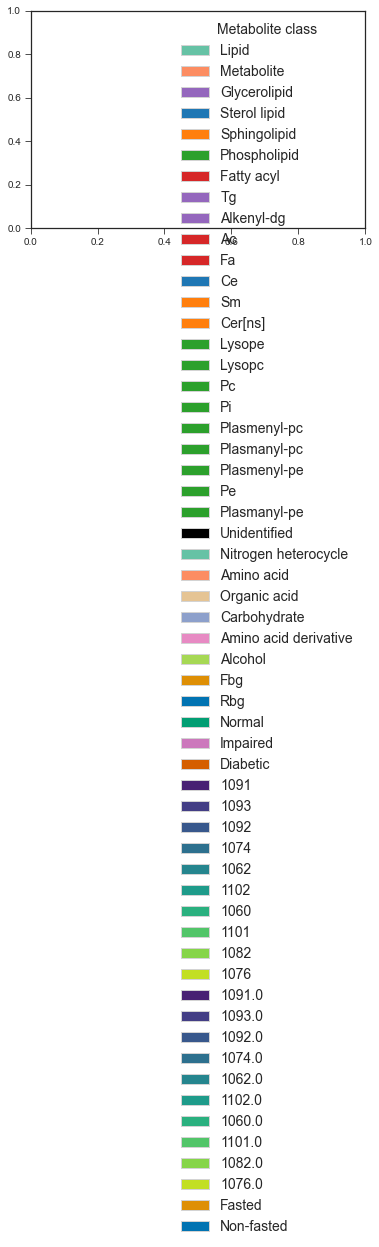

In [113]:
# TESTING LEGENDS 
handles = []
labels = []
for metab, m_color in colors.items():
    if metab == 'Unidentified':
        m_color = 'black'
    labels.append(metab.capitalize())
    handles.append(Patch(edgecolor='lightgray', facecolor=m_color))

plt.legend(handles, labels, title='Metabolite class', title_fontsize=14, fontsize=14)

Text(0, 0, '80 Polar\nMetabolites')

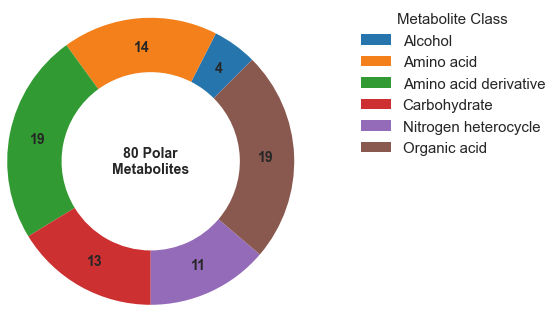

In [114]:
fig, ax = plt.subplots(figsize=(5,5))
ax.set_aspect('equal')
m_wedges, m_texts = ax.pie(
    mc,
    labels=mc.index.astype('str').str.capitalize(),
    labeldistance=0.80,
    radius=1.32,
    colors=sns.color_palette('tab10', len(mc), desat=0.9),
    wedgeprops=dict(width=0.5),
    textprops=dict(fontsize=14, fontweight='bold', ha='center', ),
    startangle=45,
)
[text.set_text(count) for text, count in zip(m_texts, mc)]
plt.legend(loc=(1.25, 0.5), fontsize=15, title='Metabolite Class', title_fontsize=15)
ax.text(0, 0, f'{mc.sum()} Polar\nMetabolites', fontsize=14, fontweight='semibold', ha='center', va='center')

In [164]:
# lsc = (data  
#     .loc[data['Type'] == 'lipid', 'superclass']
#     .value_counts()
#     .drop('Unidentified')
#     .sort_index()
#     )

# lc = (data  
#     .loc[(data['Type'] == 'lipid') & (data['superclass'] != 'Unidentified'), ['molec_class']]
#     .value_counts()
#     .reset_index()
#     )
# lc['superclass'] = lc['molec_class'].map(colors)
# lc = (lc
#     .sort_values('superclass')
#     .drop('superclass', axis=1)
#     .set_index('molec_class')
#     .loc[:, 0]
#      )

# RT/mz plots

<AxesSubplot:xlabel='RT', ylabel='m/z'>

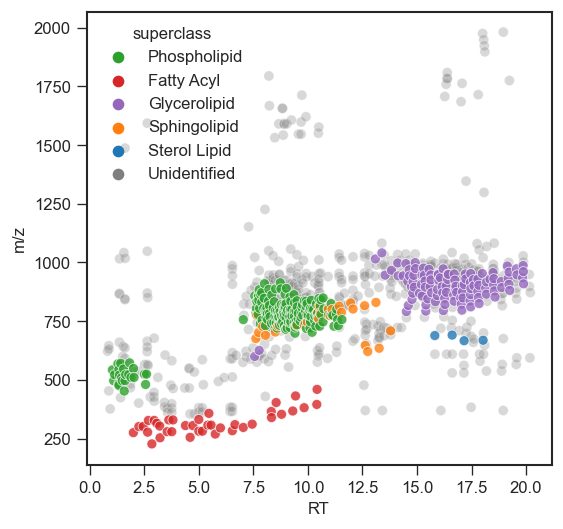

In [100]:
df = data.loc[data['Type'] == 'lipid']
fig, ax = plt.subplots(figsize=(5,5), dpi=120)
sns.scatterplot(
    data=df.loc[(df['superclass'] != 'Unidentified') & (df['molec_class'] != 'AC')],  # remove AC because from HILIC
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.8
)
sns.scatterplot(
    data=df.loc[df['superclass'] == 'Unidentified'], x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3, zorder=-10
)

<AxesSubplot:xlabel='RT', ylabel='m/z'>

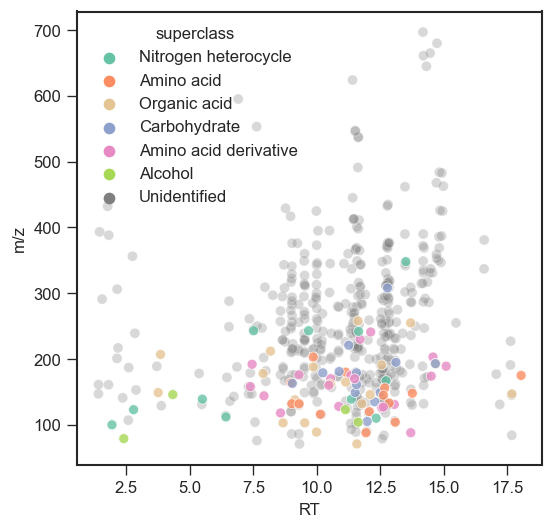

In [101]:
df = data.loc[data['Type'] == 'metabolite']
fig, ax = plt.subplots(figsize=(5,5), dpi=120)
sns.scatterplot(
    data=df.loc[(df['superclass'] != 'Unidentified') & (df['molec_class'] != 'AC')],  # remove AC because from HILIC
    x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.8
)
sns.scatterplot(
    data=df.loc[df['superclass'] == 'Unidentified'], x='RT', y='m/z', hue='superclass', palette=colors,
    alpha=0.3, zorder=-10
)

In [102]:
df

,unique_id,ID,m/z,RT,molec_class,Type,polarity,lc_type,superclass,1091_8_FBG,...,qval_sampling,qval_ogtt,qval_sampling:ogtt,pval_sampling,pval_ogtt,pval_sampling:ogtt,qval_fed,qval_fasted,pval_fed,pval_fasted
i,,,,,,,,,,,,,,,,,,,,,
m_0,Unidentified_2.353_141.0659,Unidentified,141.06591,2.353,Unidentified,metabolite,-,HILIC,Unidentified,18.724636,...,6.107470e-01,0.000223,0.625991,5.498881e-01,2.801501e-05,0.520258,0.005188,0.047076,1.774542e-03,0.005889
m_1,Unidentified_11.539_180.0585,Unidentified,180.05850,11.539,Unidentified,metabolite,-,HILIC,Unidentified,20.779580,...,2.704523e-10,0.002746,0.000131,6.116236e-11,6.111934e-04,0.000003,0.000001,0.563346,3.159016e-08,0.337609
m_2,Urocanic acid_11.365_139.0503,Urocanic acid,139.05028,11.365,Nitrogen heterocycle,metabolite,+,HILIC,Nitrogen heterocycle,24.180859,...,1.839761e-01,0.655652,0.682464,1.412000e-01,5.348448e-01,0.582536,0.559416,0.980767,4.526725e-01,0.955407
m_3,Uridine_7.513_243.0615,Uridine,243.06152,7.513,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,24.887680,...,1.238196e-10,0.085684,0.530633,2.563897e-11,4.002608e-02,0.416631,0.525163,0.115738,4.126169e-01,0.029282
m_4,Uric acid_12.732_167.0201,Uric acid,167.02007,12.732,Nitrogen heterocycle,metabolite,-,HILIC,Nitrogen heterocycle,27.518513,...,4.040584e-01,0.040484,0.251925,3.452344e-01,1.625088e-02,0.151978,0.558230,0.073041,4.510871e-01,0.013072
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
m_490,Unidentified_6.857_188.0708,Unidentified,188.07080,6.857,Unidentified,metabolite,-,HILIC,Unidentified,17.634630,...,4.455072e-19,0.236182,0.129122,2.361345e-20,1.387050e-01,0.062885,0.770687,0.193054,6.857205e-01,0.062199
m_491,Unidentified_1.403_161.1325,Unidentified,161.13253,1.403,Unidentified,metabolite,+,HILIC,Unidentified,19.227724,...,7.502939e-01,0.293052,0.016376,7.068140e-01,1.822513e-01,0.003890,0.308081,0.054284,2.148943e-01,0.007442
m_492,Unidentified_8.657_229.0434,Unidentified,229.04342,8.657,Unidentified,metabolite,-,HILIC,Unidentified,21.181276,...,1.117216e-01,0.681286,0.039568,8.148177e-02,5.642878e-01,0.013562,0.294815,0.105230,2.020989e-01,0.024303


In [ ]:
# cm.ax_row_colors.set_xticklabels(['# unsaturations', '# FA carbons'], fontsize=12)
# Unsaturations colorbar
# sm = plt.cm.ScalarMappable(cmap=ListedColormap(unsat_palette))
# sm.set_array(range(0, max_unsats+1))
# unsat_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
# unsat_cbar.ax.tick_params(labelsize=12)
# unsat_cbar.ax.yaxis.set_label_position('left')
# unsat_cbar.ax.set_ylabel('Num. unsaturations', fontsize=14)

# Carbons colorbar
# sm = plt.cm.ScalarMappable(cmap=ListedColormap(carbons_palette))
# sm.set_array(range(min_carbons, max_carbons))
# carbons_cbar = fig.colorbar(sm, ax=cm.ax_col_dendrogram, orientation='vertical', drawedges=True)
# carbons_cbar.ax.tick_params(labelsize=12)
# # unsat_cbar.ax.yaxis.set_label_position('left')
# carbons_cbar.ax.set_ylabel('Num. carbons', fontsize=14)

In [ ]:
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
from matplotlib.patches import Ellipse, Patch
import numpy as np
import seaborn as sns
plt.rcParams['svg.fonttype'] = 'none'
plt.rcParams['pdf.use14corefonts'] = True
plt.rcParams['axes.unicode_minus'] = False  # https://stackoverflow.com/questions/43102564/matplotlib-negative-numbers-on-tick-labels-displayed-as-boxes
plt.style.use('seaborn-ticks')  # 'seaborn-ticks', 'seaborn-white', 'seaborn'

scaled = StandardScaler().fit_transform(data[data_cols].T)
pca_object = PCA(n_components=10).fit(scaled)
pca = pca_object.transform(scaled)
pc_columns = [f'pc{x}' for x in range(1, pca_object.n_components+1)]
pca = pd.DataFrame(pca, index=data_cols, columns=pc_columns)
pca = pca.join(YOUR_METADATA_TABLE['YOUR GROUP HERE'])
pca['YOUR GROUP HERE'] = pca['YOUR GROUP HERE'].astype('str')

loadings = pd.DataFrame(pca_object.components_.T * np.sqrt(pca_object.explained_variance_), 
                        index=data.index, columns=pc_columns)
loadings['pc1_rank'] = loadings['pc1'].abs().rank(ascending=False)
loadings['pc2_rank'] = loadings['pc2'].abs().rank(ascending=False)
loadings = loadings.join(data['ID'])
loadings.loc[loadings['ID'] != 'unknown'].sort_values('pc2_rank').iloc[:20]

# Draw confidence intervals around data: 
# From https://stackoverflow.com/a/25022642
def make_ci(x, y, std=2, **kwargs):
    cov = np.cov(x, y)
    vals, vecs = np.linalg.eigh(cov)
    order = vals.argsort()[::-1]
    vals = vals[order]
    vecs = vecs[:, order]
    theta = np.degrees(np.arctan2(*vecs[:, 0][::-1]))
    w, h = 2 * std * np.sqrt(vals)
    ellipse = Ellipse(xy=(np.mean(x), np.mean(y)), width=w, height=h, angle=theta, 
                      **kwargs)
    return ellipse

def pca_plot(ax=None):
    if ax is None:
        fig, ax = plt.subplots(figsize=(4.5, 3.5), dpi=100)
    sns.scatterplot(
        data=pca, x='pc1', y='pc2', 
        hue='YOUR GROUP HERE', palette=colors,
        legend=True, alpha=1, linewidth=1.2, edgecolor='0.15',
        ax=ax)
    ax.set_xlabel(f'PC1 — {round(100*pca_object.explained_variance_ratio_[0], 1)}%', fontsize=10) 
    ax.set_ylabel(f'PC2 — {round(100*pca_object.explained_variance_ratio_[1], 1)}%', fontsize=10) 
    sns.despine(ax=ax)
pca_plot()
# plt.savefig('../reports/figures/Figure2/PCA.pdf', dpi=150, bbox_inches='tight')